# 扩散模型

我们定义这么一个过程：给一张图片逐步加噪声直到变成纯粹的噪声，然后对噪声进行去噪得到真实的图片。所谓的扩散模型就是让神经网络学习这个去除噪声的方法。

In [1]:
import torch
import math
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, einsum
from einops import rearrange
from functools import partial
from inspect import isfunction

## 定义组件

### Network helpers

In [2]:
def exists(x):
    return x is not None

# 有val时返回val，val为None时返回d
def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# 残差模块，将输入加到输出上
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# 上采样（反卷积），使用该转置卷积层，输入特征图的尺寸将被增加大约一倍
def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

# 下采样，输入特征图的尺寸将被减少大约一半
def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Positional embeddings
类似于Transformer的positional embedding，为了让网络知道当前处理的是一系列去噪过程中的哪一个step，我们需要将步数也编码并传入网络之中。DDPM采用正弦位置编码（Sinusoidal Positional Embeddings）

这一方法的输入是shape为 (batch_size, 1) 的 tensor，也就是batch中每一个sample所处的,并将这个tensor转换为shape为 (batch_size, dim) 的 tensor。这个tensor会被加到每一个残差模块中。

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)# 计算缩放因子
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)# 生成基础频率
        embeddings = time[:, None] * embeddings[None, :]# 应用位置信息
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)# 最终位置编码
        return embeddings

### ResNet/ConvNeXT block

In [4]:
class Block(nn.Module):# 基本卷积块：一个卷积，一个归一，一个激活
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)# 3*3卷积层，不变大小
        self.norm = nn.GroupNorm(groups, dim_out)
        '''组归一化，特别是当数据在通道维度上有明显的分组结构时。
        分组归一化则将特征通道分为若干组，然后在每个组内进行归一化。'''
        self.act = nn.SiLU()# 应用Sigmoid激活函数

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            # 如果提供了scale_shift参数，会对卷积后的特征进行尺度变换和平移，这在某些条件化模型中很有用。
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """残差网络中基本块：残差块通过引入跳过连接来帮助信息流过深层网络，减轻梯度消失问题。
    输入和输出尺寸维度一样"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )# 时间嵌入处理层: 如果提供了time_emb_dim，使用一个线性层和SiLU激活函数处理时间嵌入，用于条件生成任务。

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        ''' nn.Identity()返回输入本身。这个函数常被用于在神经网络中添加“跳过”连接（skip connections）
        这是一种在ResNet等深度神经网络中广泛使用的技巧。'''

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            '''即使time_emb_dim被设置了，也有可能在某次前向传播中不使用时间嵌入
            （例如，在评估模型时可能不需要时间信息）。因此，需要在每次前向传播时检查time_emb是否实际被提供。'''
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h# 与特征图相匹配的形状（b c 1 1），其中b是批次大小，c是通道数。
        '''如果定义了self.mlp（即time_emb_dim不为None）并且提供了时间嵌入（time_emb），
        那么时间嵌入首先被self.mlp处理，然后通过rearrange改变其形状以匹配h（block1的输出），并加到h上。
        这一步允许模型将时间信息融入到其空间特征中，实现条件生成。'''

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """A ConvNet for the 2020s,
    受Transformer架构启发，采用分组卷积（nn.Conv2d 使用 groups=dim 参数）来降低参数数量并提高计算效率，
    同时使用GELU激活函数。"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )# GELU的优点：与ReLU相比，GELU在负区间上的梯度不会消失，因此可能有助于解决深度神经网络中的“死亡ReLU”问题。

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )# 使用mult参数控制扩展的倍数
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

两种attention模块，一个是常规的 multi-head self-attention，一个是 linear attention variant

In [5]:
class Attention(nn.Module):# 四头，每头32维向量，典型的多头注意力机制
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        '''self.to_qkv的输出尺寸为(b, hidden_dim * 3, h, w)
        这里的hidden_dim等于 dim_head * heads 是每个注意力头的维度乘以头的数量
        3表示将输出分为查询（Q）、键（K）和值（V）三部分'''
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)# 将注意力机制的输出转换回原始输入的通道数

    def forward(self, x):
        b, c, h, w = x.shape# 输入特征图x的尺寸为(b,c,h,w)，其中b是批大小，c是通道数，h和w分别是特征图的高度和宽度。
        qkv = self.to_qkv(x).chunk(3, dim=1)# 先拆出来Q、K、V
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        '''map函数将lambda函数应用于qkv的每个元素（在这里，是Q、K、V三个块
        对输入t（依次是 Q、K、V 的每部分）的维度进行重新排列。这里的t初始形状为(b,hidden_dim,h,w)
        将原来的 hidden_dim 拆分成 heads (h) 和每个头的维度 c（即 dim_head）
        将图像的宽（x）和高（y）维度合并成一个维度，使得每个头处理的是一个长向量，其长度是h*w（即后面Q中的i）
        此时形状变为(b,h,c,h*w)即（批次，头，头的维度，长宽向量乘积）'''
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)# 一个批次内所有头的所有查询与所有键之间的点积即Q/scale*K
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        '''这部分代码找到 sim 矩阵在最后一个维度（dim=-1，即每行）上的最大值。
        参数 keepdim=True 保持输出的维度与原矩阵相同，这样就可以直接与原矩阵进行元素级别的操作，而不改变其形状
        .detach()：这个操作用于从当前计算图中分离出最大值张量，意味着这个操作后的结果不会参与梯度计算
        目的是确保 sim 矩阵中的每行最大值为 0，其余值都是负数，
        这可以防止在随后应用softmax函数时因为极大的指数值导致的数值溢出问题。'''
        attn = sim.softmax(dim=-1)# softmax(Q/scale*K)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)# softmax(Q/scale*K)*V
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)# 重新整理回原有的维度
        return self.to_out(out)

class LinearAttention(nn.Module):
    '''线性注意力的一种常见形式，可以表示为：Attention(Q,K,V)=ϕ(Q) * (ϕ(K)^T * V)
ϕ是一个特征映射函数，它可以是任何满足特定性质的函数（如正定核函数）
通过这种方式，这可以在低维空间中高效完成，从而降低整个操作的复杂度
计算效率：线性注意力将复杂度从O(n^2)降低到O(n)，其中n是序列长度'''
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)# 特征映射函数是softmax
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

## 定义完整网络

### Conditional U-Net

- Input：a batch of noisy images of shape (batch_size, num_channels, h, w) and a batch of steps of shape ( batch_size, 1) 网络需要的输入：噪声图片的batch+这些图片各自的时刻t
- output: a tensor of shape (batch_size, num_channels, h, w) 输出：预测每个图片上所添加的噪声

具体的网络结构：
- 首先，输入通过一个卷积层，同时计算step(t)所对应得embedding
- 通过一系列的下采样stage，每个stage都包含：2个ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + downsample operation
- 在网络中间，应用一个带attention的ResNet或者ConvNeXT
- 通过一系列的上采样stage，每个stage都包含：2个ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + upsample operation
- 最终，通过一个ResNet/ConvNeXT blocl和一个卷积层。

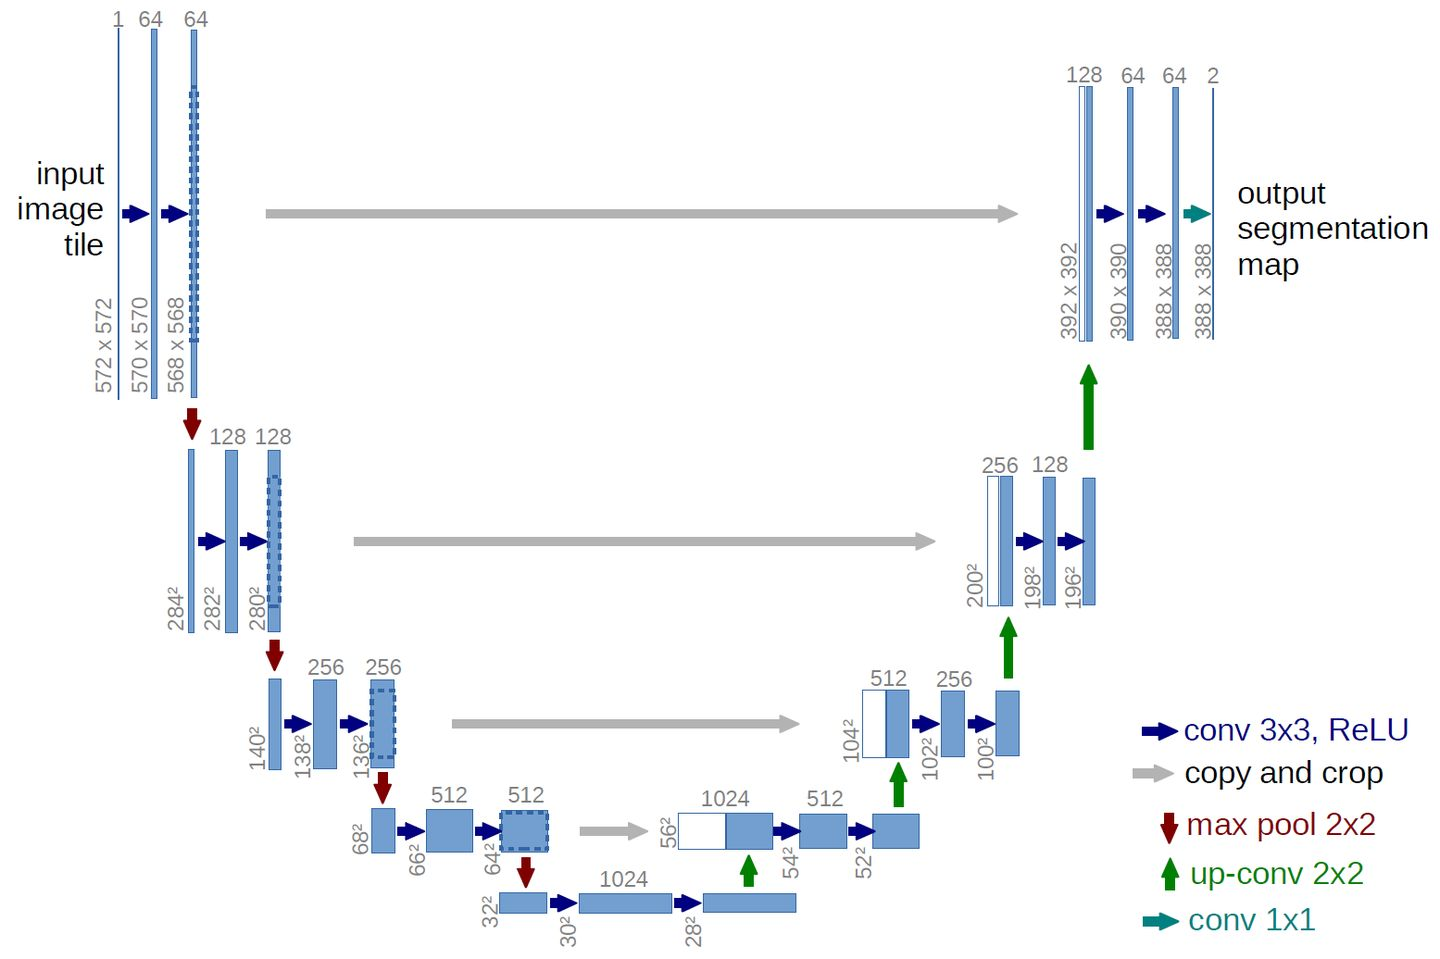

In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)# 如果init_dim没有显式提供，它会被设置为dim // 3 * 2
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]# 基于dim_mults（维度乘数元组）生成一个维度列表dims
        in_out = list(zip(dims[:-1], dims[1:]))# 每个元组包含相邻层的输入和输出维度，用于定义网络中的每一层
        
        if use_convnext:# 选择使用扩展2倍通道数的ConvNeXt，还是使用8组组归一化的Resnet
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        # 初始化两个ModuleList，分别用于存储网络的下采样（编码器）和上采样（解码器）路径中的模块
        num_resolutions = len(in_out)# 记录维度变换的次数

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1) #此处保证最后一层使用nn.Identity
            ''' is_last变量并不是因为层数不固定或者无法自动停止循环，而是为了确保在动态构建网络时，最后一层的特殊情况得到正确处理。
            这种设计模式提高了代码的通用性和灵活性，使得同一套代码能够适应不同的网络配置和需求。'''
            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):# 除去最后一层，也即第一层输入层，现在变成了输出层
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            '''“跳过连接”（Skip Connection），它是 U-Net 架构的一个核心组成部分。
            跳过连接允许网络将编码器（下采样路径）中的特征直接与解码器（上采样路径）中的特征进行融合，
            从而在解码过程中保留更多的空间信息，有助于更好地重建图像细节。'''
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## 定义前向扩散过程

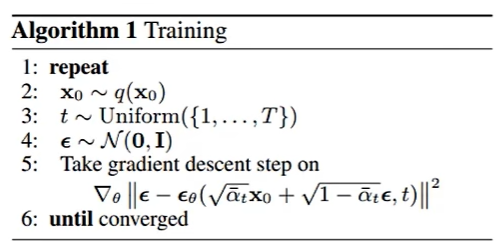

### 定义β
DDPM中的β使用linear schedule定义。后续的研究指出使用cosine schedule可能会有更好的效果。
接下来是一些简单的对于schedule的定义，从当中选一个使用即可。

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    '''这个函数使用余弦函数来平滑地调整β值。通过这种方式，β值在训练过程中的变化更为平滑，有助于稳定学习过程。'''
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)
'''torch.clip函数会遍历输入张量中的每个元素，并将小于 min 的元素替换为 min，将大于 max 的元素替换为 max
这样可以确保输出张量的元素位于指定的范围内'''

def linear_beta_schedule(timesteps):
    '''β值从beta_start线性增加到beta_end。'''
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)
'''torch.linspace会在指定的起始值和结束值之间均匀地生成一组数值，这些数值的个数由 steps 参数指定
生成的数值会填充在一个一维张量中，这个张量的形状为 (steps,)'''

def quadratic_beta_schedule(timesteps):
    '''β的调整基于二次函数关系，先平方根后线性增加，再平方，使其增长速度开始较慢，后期加快'''
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    '''Sigmoid 函数用于产生一个平滑的、S形的β值变化曲线，从beta_start渐进地增加到beta_end
    这种方法在初期和后期β值的变化较为平缓，而在中间阶段变化较快。'''
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

### 前向过程准备
将T设置为1200，并将每个t下的各种参数提前计算好，包括β、α以及反向扩散时候固定的方差项

In [9]:
timesteps = 1200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)# 计算累积乘积
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) 
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

''' calculations for diffusion q(x_t | x_{t-1}) and others，
用于在扩散过程中缩放加入的噪声'''
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

''' calculations for posterior q(x_{t-1} | x_t, x_0)
后验方差。这是根据扩散过程的数学推导得到的公式，用于在反向过程中（从噪声数据重构原始数据）的采样步骤。'''
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    '''这是一个辅助函数，用于从给定的张量a中根据时间步张量t提取对应的值。
    它首先确定批次大小，然后使用torch.gather在最后一个维度上根据t提取a的值,并保证输出与输入x具有相同的形状.
    除了时间维度之外。这种提取方式在处理与时间步相关的参数时非常有用。'''
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)# 通用模型，所以没有使用定长

### 引入一个实例

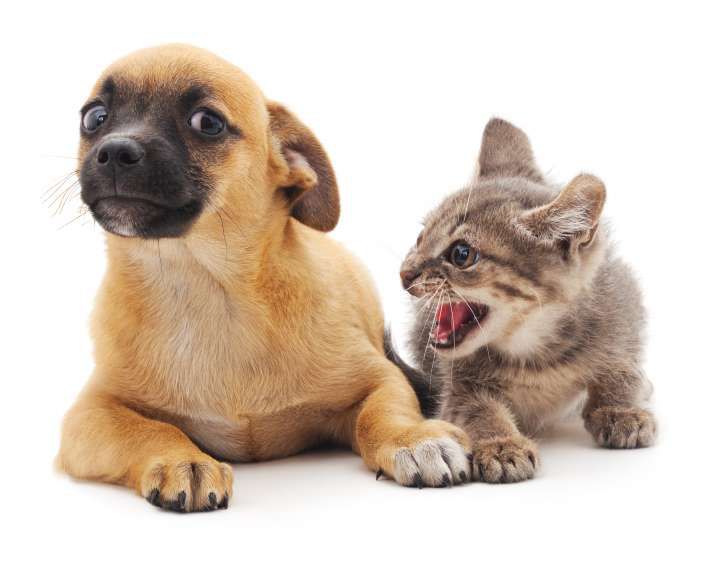

In [10]:
from PIL import Image
image = Image.open('/home/ly/miniconda3/envs/shiwei/data/catdog.jpg')
image

In [11]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),# 标准化，从(0,1)变为(-1,1)
])

x_start = transform(image).unsqueeze(0)
x_start.shape  # 输出的结果是 torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])

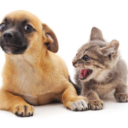

In [12]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

reverse_transform(x_start.squeeze())

### 定义正向扩散过程

In [13]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)# 生成随机白噪
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)
  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())
  return noisy_image

定义采样多个t并且展示图片的方法

In [14]:
# use seed for reproducability
torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    '''这段代码定义了一个函数 plot，用于在一个网格中绘制一系列图像。
    该函数具有灵活性，允许你选择是否包含原始图像作为每行的第一张图像，并且可以为每行设置标题'''
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            '''asarray函数将图像(img)转换为NumPy数组。Matplotlib通常需要图像数据以NumPy数组的形式来进行处理和显示
            **imshow_kwargs: 这些参数可能包括例如cmap（色彩映射）、vmin和vmax（颜色范围）、interpolation（插值方法）等等'''
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])# ax.set用于移除坐标轴上的标签和刻度

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [15]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 100, 200, 500, 999]])

## 损失函数
1. 先采样噪声
2. 用这个噪声去加噪图片
3. 根据加噪了的图片去预测第一步中采样的噪声

In [16]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    # 先采样噪声
    if noise is None:
        noise = torch.randn_like(x_start)
    
    # 用采样得到的噪声去加噪图片
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)
    
    # 根据加噪了的图片去预测采样的噪声
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)# 平均绝对误差（L1损失）
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)# 均方误差（MSE损失）
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise) # Huber损失（平滑L1损失）结合了L1损失的抗噪声特性以及类似于L2损失的平滑性
    else:
        raise NotImplementedError()

    return loss

## 采样

定义数据集：使用经典手写mnist数据集

In [23]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

trans = Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

mnist_train = datasets.MNIST(
    root="/home/ly/miniconda3/envs/shiwei/data", train=True, transform=trans, download=True)
mnist_test = datasets.MNIST(
   root="/home/ly/miniconda3/envs/shiwei/data", train=False, transform=trans, download=True)

image_size = 28
channels = 1
batch_size = 128

train = DataLoader(mnist_train, batch_size, shuffle=True)
test= DataLoader(mnist_test, batch_size, shuffle=False)
batch = next(iter(train))
print(batch[0][0])

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

### 逆向过程，开始采样

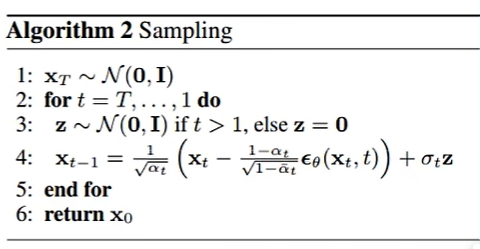

采样过程发生在反向去噪时。对于一张纯噪声，扩散模型一步步地去除噪声最终得到真实图片，采样事实上就是定义的去除噪声这一行为。 

观察上图中第四行， t-1步的图片是由 t步的图片减去一个噪声得到的，只不过这个噪声是由**神经网络**拟合出来，并且 rescale过的而已。这里要注意第四行式子的最后一项，**采样时每一步也都会加上一个从正态分布采样的纯噪声**。

In [18]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)# t时刻的β
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )# t时刻的根号下1-累乘α
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)# t时刻的根号下1/α
    
    # Algorithm 2 line 4:
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:# 这是定方差
        return model_mean
    else:# 这是随着t变化的方差
        posterior_variance_t = extract(posterior_variance, t, x.shape) #t时刻的方差
        noise = torch.randn_like(x)
        # Algorithm 2 line 4 + noise:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):# p_sample_loop函数是一个用于生成图片的循环采样过程
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)# 初始化了一个大小为shape的随机张量img，用于表示初始图片
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)# 此处t的形式与extract函数有关
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):# sample函数是一个用于生成图片的外部接口。
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

创建一个存放逆向过程生成图片的文件夹

In [19]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path('/home/ly/miniconda3/envs/shiwei/Diffusion初步实验图片/MINIST')
results_folder.mkdir(exist_ok = True)# Create a new directory at this given path.

模型&优化器准备

In [20]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

开始训练

In [21]:
from torchvision.utils import save_image

epochs = 8

for epoch in range(epochs):
    for step, batch in enumerate(train):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images(每200t存储)
      if step !=0 and (step % 200 ==0 or step == len(train)-1):
        milestone = step // 200
        batches = num_to_groups(6, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels, image_size=image_size), batches))
        flattened_images_list = [torch.from_numpy(image).to(device) for sublist in all_images_list for image in sublist]
        flattened_images_list = [image.to(device) for image in flattened_images_list]
        all_images = torch.cat(flattened_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.47219547629356384
Loss: 0.08052295446395874
Loss: 0.026936477050185204


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 102.07it/s]


Loss: 0.03086635284125805
Loss: 0.022064998745918274


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.92it/s]


Loss: 0.019291691482067108
Loss: 0.01355699822306633
Loss: 0.01747443899512291


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.58it/s]


Loss: 0.01938370242714882
Loss: 0.01675712689757347


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.79it/s]


Loss: 0.017254337668418884
Loss: 0.01939847320318222
Loss: 0.017480630427598953


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.20it/s]


Loss: 0.01692468486726284
Loss: 0.011061513796448708


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.57it/s]


Loss: 0.015561331994831562
Loss: 0.011557921767234802
Loss: 0.01290974672883749


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.56it/s]


Loss: 0.014397363178431988
Loss: 0.011852114461362362


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 101.09it/s]


Loss: 0.013576563447713852
Loss: 0.015025170519948006
Loss: 0.013980269432067871


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.60it/s]


Loss: 0.013458413071930408
Loss: 0.01220082025974989


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 101.19it/s]


Loss: 0.015271907672286034
Loss: 0.011183144524693489
Loss: 0.011048556305468082


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.45it/s]


Loss: 0.010585390962660313
Loss: 0.013564648106694221


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.93it/s]


Loss: 0.0125873489305377
Loss: 0.012556428089737892
Loss: 0.009820351377129555


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.68it/s]


Loss: 0.012243129312992096
Loss: 0.01076816488057375


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 101.17it/s]


Loss: 0.010087070986628532
Loss: 0.014883418567478657
Loss: 0.012216380797326565


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.23it/s]


Loss: 0.012881073169410229
Loss: 0.01146598719060421


sampling loop time step: 100%|████████████| 1200/1200 [00:11<00:00, 100.72it/s]


sampling loop time step:   0%|                        | 0/1200 [00:00<?, ?it/s]

sampling loop time step: 100%|█████████████| 1200/1200 [00:12<00:00, 96.35it/s]


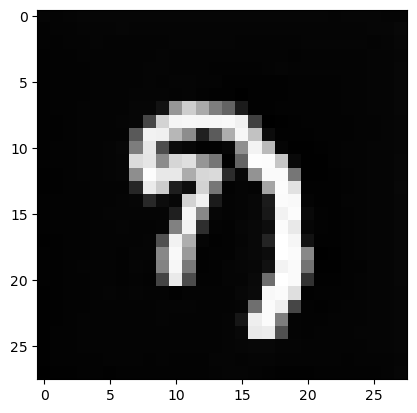

In [22]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 10
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")